In [3]:
import csv
import pandas as pd
import numpy as np
import json
#import sklearn
from collections import Counter
import matplotlib.pyplot as plt
import random

In [4]:
#Read all_winners_array.json
with open('all_winners_array.json') as json_file:
    all_winners_array = json.load(json_file)
res = {"paper":{"scissors":("L","UP"),"rock":("W","DOWN"),"paper":("T","STAY")},
    "scissors":{"paper":("W","DOWN"),"rock":("L","UP"),"scissors":("T","STAY")},
    "rock":{"paper":("L","UP"),"scissors":("W","DOWN"),"rock":("T","STAY")}}


In [5]:
fixed_dict = {0: 1, 1: 2, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 0, 10: 1, 11: 4, 12: 1, 13: 0, 14: 1, 15: 2, 16: 1, 17: 1, 18: 2, 19: 2, 20: 3, 21: 2, 22: 1, 23: 1, 24: 0, 25: 1, 26: 1, 27: 2, 28: 1, 29: 2}

In [6]:
all_trans_mat = []
for winner in all_winners_array:
    action_dict = Counter(winner)
    new_action_dict = {k:v/len(winner) for k, v in action_dict.items()}
    for key in new_action_dict:
        if 'N' in key:
            print(winner.index(key), all_winners_array.index(winner))
    all_trans_mat.append(new_action_dict)

all_trans_mat_np = []
for m in all_trans_mat:
    arr = np.array([[m['WU'],m['WD'],m['WS']],[m['LU'],m['LD'],m['LS']],[m['TU'],m['TD'],m['TS']]])
    all_trans_mat_np.append(arr)

In [7]:
list_all = [[all_trans_mat_np[key] for key, value in fixed_dict.items() if value == i] for i in range(5)]
av_all = [np.mean(l, axis=0) for l in list_all]

av_dict_list = []
for av in av_all:
    av_dict = {}
    av_dict['W'] = av[0]
    av_dict['L'] = av[1]
    av_dict['T'] = av[2]
    av_dict_list.append(av_dict)


In [12]:
reverseres = {"paper":{"U":"scissors","D":"rock","S":"paper"},
                "rock":{"U":"paper","D":"scissors","S":"rock"},
                "scissors":{"U":"rock","D":"paper","S":"scissors"}}

def playernextaction(player:dict, lastaction, lastresult):
    udsaction = random.choices(("U","D","S"),weights=player[lastresult],k=1)[0]
    actualact = reverseres[lastaction][udsaction]
    return actualact

def compete(player1:dict, player2:dict, num_rounds:int):
    options = ("rock", "paper", "scissors")
    log = [] #each entry is (p1action, p2action, p1outcome "WLT", p2outcome "WLT")
    p1actionlog = []
    p2actionlog = []
    p1outcomelog = []
    p2outcomelog = []
    
    starting1 = random.choice(options)
    starting2 = random.choice(options)
    p1actionlog.append(starting1)
    p2actionlog.append(starting2)
    p1outcomelog.append(res[p1actionlog[-1]][p2actionlog[-1]][0])
    p2outcomelog.append(res[p2actionlog[-1]][p1actionlog[-1]][0])

    for i in range(num_rounds):
        p1action = playernextaction(player1, p1actionlog[-1], p1outcomelog[-1])
        p2action = playernextaction(player2, p2actionlog[-1], p2outcomelog[-1])
        p1actionlog.append(p1action)
        p2actionlog.append(p2action)
        p1outcomelog.append(res[p1actionlog[-1]][p2actionlog[-1]][0])
        p2outcomelog.append(res[p2actionlog[-1]][p1actionlog[-1]][0])
    
    log = list(zip(p1actionlog, p2actionlog, p1outcomelog, p2outcomelog))
    return log    
        
def maketournament(playerlist, num_rounds):
    num_players = len(playerlist)
    scores = np.zeros((num_players,num_players,3))
    for i in range(num_players):
        for j in range(i+1,num_players):
            log = compete(playerlist[i], playerlist[j], num_rounds)
            p1score = (sum([1 if x[2]=="W" else 0 for x in log])/num_rounds, sum([1 if x[2]=="L" else 0 for x in log])/num_rounds, sum([1 if x[2]=="T" else 0 for x in log])/num_rounds)
            p2score = (sum([1 if x[3]=="W" else 0 for x in log])/num_rounds, sum([1 if x[3]=="L" else 0 for x in log])/num_rounds, sum([1 if x[3]=="T" else 0 for x in log])/num_rounds)
            scores[i,j] = p1score
            scores[j,i] = p2score
    return scores


def makentournaments(playerlist, num_rounds, num_tournaments):
    num_players = len(playerlist)
    scoreboards = np.zeros((num_tournaments,num_players,num_players,3))
    for i in range(num_tournaments):
        scoreboards[i] = maketournament(playerlist, num_rounds)
    return scoreboards

scoreboards = makentournaments(av_dict_list, 1000, 200)
tournament_avg = np.mean(scoreboards, axis=0) #shape is nxnx3

(array([  0.,  11.,   0.,   4.,   0., 104.,   0.,  15.,   0.,   0.]),
 array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]),
 <BarContainer object of 10 artists>)

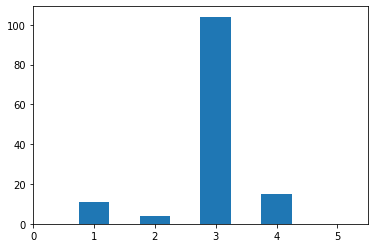

In [13]:
s = scoreboards.shape
best_group = []
for i in range(s[0]):
    trial = scoreboards[i]
    list_of_avgs = [np.average(trial[j,:,0]) for j in range(s[1])]
    best_group.append(list_of_avgs.index(max(list_of_avgs)))
#Plot a histogram of the best group
#Center the bins on the integers
#Make bins have width 0.5
plt.hist(best_group, bins=np.arange(0.25, 5.75, 0.5), align='mid')

In [14]:


#get a board of binary win/losses from the scoreboard
#apply this to individual scoreboards to get the win/losses from individual tournaments
#apply this to tournament average to see who beats who on average
def winboard(scoreboard):
    num_players = scoreboard.shape[0]
    winboard = np.zeros((num_players,num_players))
    for i in range(num_players):
        for j in range(i+1,num_players):
            if scoreboard[i,j,0] > scoreboard[j,i,0]:
                winboard[i,j] = 1
            elif scoreboard[i,j,0] < scoreboard[j,i,0]:
                winboard[j,i] = 1
            elif scoreboard[i,j,0] == scoreboard[j,i,0]:
                winboard[i,j] = 0.5
                winboard[j,i] = 0.5

    return winboard

print("final winboard", winboard(tournament_avg))

def cumwinboard(scoreboards):
    num_tournaments = scoreboards.shape[0]
    num_players = scoreboards.shape[1]
    cumwinboard = np.zeros((num_players,num_players))
    for i in range(num_tournaments):
        cumwinboard += winboard(scoreboards[i])
    return cumwinboard

print("cumulative winboard", cumwinboard(scoreboards))

final winboard [[0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
cumulative winboard [[  0.   27.   31.  196.  180.5]
 [173.    0.  150.    0.  169. ]
 [169.   50.    0.    3.  189. ]
 [  4.  200.  197.    0.    6. ]
 [ 19.5  31.   11.  194.    0. ]]


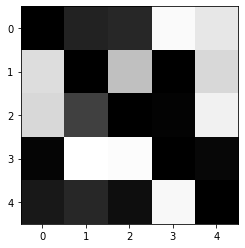

In [15]:
#Visualize the cumulative winboard
plt.imshow(cumwinboard(scoreboards), cmap='gray', interpolation='nearest')